In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import lingam
from lingam import DirectLiNGAM
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score
from causallearn.utils.GraphUtils import GraphUtils







df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)



In [3]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
feature_names = df_clean.columns.tolist()


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [6]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [7]:
X_lingam = df.drop(columns=['average_power_consumption'])


In [8]:
X_lingam_numeric = X_lingam.select_dtypes(include=['float64', 'int64'])

model = DirectLiNGAM()
model.fit(X_lingam_numeric)


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in scalar divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.413e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.071e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.033e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.215e-08. Red

In [9]:
print("Estimated causal ordering:")
print(model.causal_order_)


Estimated causal ordering:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [10]:
causal_order = model.causal_order_
feature_names = X_lingam_numeric.columns
print("Causal order (by name):")
print([feature_names[i] for i in causal_order])


Causal order (by name):
['Unnamed: 0', 'start_time', 'end_time', 'edge', 'meterID', 'processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']


In [11]:
adjacency_matrix = model.adjacency_matrix_

# print("Causal Structure (Adjacency Matrix):")
# print(adjacency_matrix)

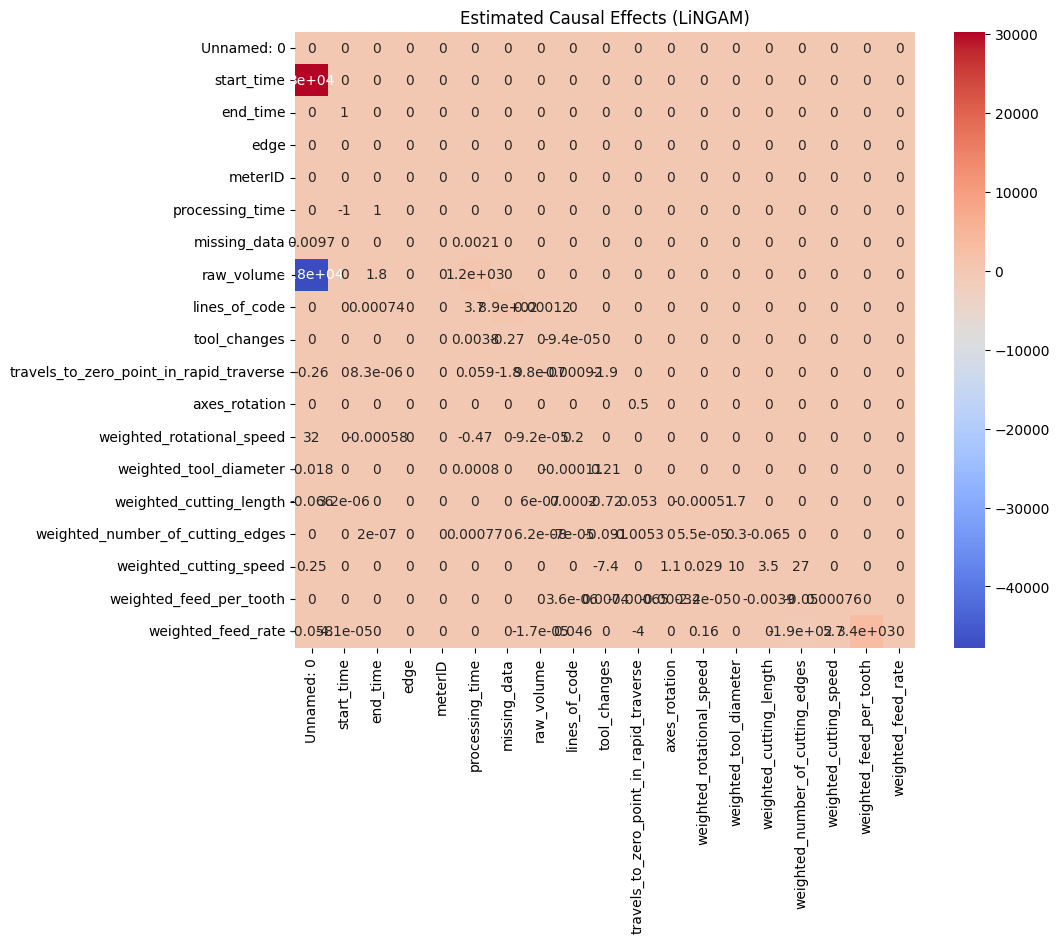

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_matrix, xticklabels=feature_names, yticklabels=feature_names, annot=True, cmap="coolwarm")
plt.title("Estimated Causal Effects (LiNGAM)")
plt.show()

In [13]:
X_with_target = df.select_dtypes(include=['float64', 'int64'])
model.fit(X_with_target)
adj_matrix = model.adjacency_matrix_
feature_names = df.columns.tolist()
target_index = X_with_target.columns.get_loc('average_power_consumption')
causal_sources = adj_matrix[:, target_index]  
print("Features that cause average power consumption:")
for i, val in enumerate(causal_sources):
    if abs(val) > 0.05:  
        print(f"{X_with_target.columns[i]} → average_power_consumption (effect: {val:.2f})")


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in scalar divide


Features that cause average power consumption:
raw_volume → average_power_consumption (effect: 5132.87)
weighted_rotational_speed → average_power_consumption (effect: -0.89)
weighted_feed_rate → average_power_consumption (effect: -0.07)


divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.865e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=2.865e-04, previous alpha=2.859e-04, with an active set of 8 regressors.


In [14]:
def adjacency_to_edge_list(adj_matrix, feature_names, threshold=0.05):
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if abs(adj_matrix[i, j]) > threshold and i != j:
                edges.append((feature_names[i], feature_names[j]))
    return edges

def compute_metrics(true_edges, pred_edges):
    true_set = set(true_edges)
    pred_set = set(pred_edges)

    nodes = sorted(set([n for edge in true_set | pred_set for n in edge]))
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))

    for src, tgt in true_set:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    for src, tgt in pred_set:
        pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1

    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()

    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    shd_val = SHD(nx.DiGraph(true_set), nx.DiGraph(pred_set))

    return precision, recall, f1, shd_val


ground_truth_edges = [
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_rotational_speed", "average_power_consumption"),
    ("processing_time", "average_power_consumption")
]

In [15]:
def compute_metrics(true_edges, pred_edges):
    true_set = set(true_edges)
    pred_set = set(pred_edges)

    all_nodes = sorted(set([n for edge in true_set | pred_set for n in edge]))

    true_graph = nx.DiGraph()
    pred_graph = nx.DiGraph()
    true_graph.add_nodes_from(all_nodes)
    pred_graph.add_nodes_from(all_nodes)
    true_graph.add_edges_from(true_set)
    pred_graph.add_edges_from(pred_set)

    node_to_idx = {node: i for i, node in enumerate(all_nodes)}
    n = len(all_nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))

    for src, tgt in true_set:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    for src, tgt in pred_set:
        pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1

    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()

    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    shd_val = SHD(true_graph, pred_graph)

    return precision, recall, f1, shd_val


In [16]:
lingam_edges = adjacency_to_edge_list(adj_matrix, feature_names)

lingam_precision, lingam_recall, lingam_f1, lingam_shd = compute_metrics(ground_truth_edges, lingam_edges)


In [17]:
print("\n--- LiNGAM Causal Metrics ---")
print(f"Precision: {lingam_precision:.3f}")
print(f"Recall:    {lingam_recall:.3f}")
print(f"F1 Score:  {lingam_f1:.3f}")
print(f"SHD:       {lingam_shd}")


--- LiNGAM Causal Metrics ---
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
SHD:       43


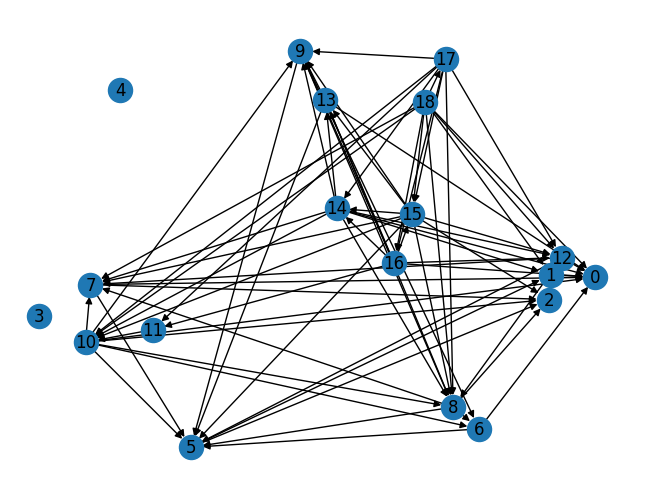

In [18]:
G = nx.DiGraph(adjacency_matrix)
nx.draw(G, with_labels=True)
plt.show()